# **Linear Algebra for Data Science**: HW3, task 3  
# *Iterative solutions of the linear systems* (3 pts)

### <div align="right"> &copy; Volodymyr Kuchynskyi & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   First team member
*   Second team member

The aim of this task is to discuss three classic iterative methods of solving linear systems $A\mathbf{x} = \mathbf{b}$, namely, the Jacobi, Gauss-Seidel, and successive over-relaxation (SOR) methods. We will implement them, analyse their convergence, and compare convergence rate with the spectral radius of the corresponding matrix $B$ in the iteration scheme $\mathbf{x}_{k+1} = B\mathbf{x}_k + \mathbf{d}$

In [1]:
import numpy as np
#Note: other common plotting libraries (such as plotly, altair, etc) or other modules of matplotlib are allowed, if you prefer them. Simply replace the next import with your library of choice
import matplotlib.pyplot as plt

# **1. The methods**

A general method to turn a linear system into an iterative one proceeds as follows. We write $A = M - N$ with an invertible $M$ and recast $A\mathbf{x} = \mathbf{b}$ as the iteration scheme
$$M\mathbf{x}_{k+1} = N\mathbf{x}_k + \mathbf{b}, \qquad \text{or} \qquad \mathbf{x}_{k+1} = (M^{-1}N)\mathbf{x}_k + M^{-1}\mathbf{b}$$

All three methods of interest are formulated in terms of the lower-triangular, diagonal, and upper-triangular parts $L$, $D$, and $U$ of $A$, respectively.



## **1.1 Jacobi method**
Take $M=D$; then with $B_J:=- D^{-1}(L+U)$ and $\mathbf{d}_J:=D^{-1} \mathbf{b}$ the iterations are
$$
  \mathbf{x}_{k+1} = B_J \mathbf{x}_k + \mathbf{d}_J
$$
or
$$
  x_j^{(k+1)} = a_{jj}^{-1}\bigl( b_j -  \sum_{l\ne j} a_{jl} x^{(k)}_l \bigr)
$$
The method is known to converge if $A$ is <font color='red'>*diagonally dominating*</font>, i.e., if $|a_{jj}|> \sum_{i\ne j}|a_{ji}|$ for all $j=1,2,\dots, n$.



## **1.2 Gauss-Seidel method**
Take $M=U+D$; then with $B_{GS}:=- (L+D)^{-1}U$ and $\mathbf{d}_{GS}:= (U+D)^{-1} \mathbf{b}$ the iterations are
$$
  \mathbf{x}_{k+1} = B_{GS} \mathbf{x}_k + \mathbf{d}_{GS}
$$
or
$$
  x_j^{(k+1)} = a_{jj}^{-1}\bigl(b_j - \sum_{l< j} a_{jl} x^{\color{red}{(k+1)}}_l  - \sum_{l > j} a_{jl} x^{(k)}_l\bigr)
$$
The method is known to converge if $A$ is <font color='red'>*positive definite*</font>


## **1.3 Successive over-relaxation method (SOR)**
SOR depends on a parameter $\omega \in (0,2)$ and starts with re-writing  $\omega A$ as $\omega A = (D + \omega L) - ((1-\omega)D - \omega U)$, so that $A\mathbf{x} = \mathbf{b}$ is converted into
$$ (D + \omega L) \mathbf{x}  = \bigl((1-\omega)D - \omega U\bigr)\mathbf{x} + \omega\mathbf{b}$$
and becomes the iteration scheme  
$$
  \mathbf{x}_{k+1} = B_{SOR} \mathbf{x}_k + \mathbf{d}_{SOR}
$$
with $B_{SOR} = (D+\omega L)^{-1}((1-\omega) D - \omega U)$ and $\mathbf{d}_{SOR} = \omega(D + \omega L)^{-1}\mathbf{b}$, or   

$$
  x_j^{(k+1)} = \frac\omega{a_{jj}} \Bigl(b_j - \sum_{l< j} a_{jl}x_l^{\color{red}{{(k+1)}}} - \sum_{l> j} a_{jl} x_l^{(k)} \Bigr)+ (1-\omega)x_j^{(k)}
$$
The method is known to converge if $A$ is <font color='red'>*positive definite*</font>; $\omega=1$ coincides with the Gauss-Seidel method but other $\omega\in (0,2)$ can significantly improve the convergence rate.

# **2. Implementation (1 pt)**

By default, the iterations start with $\mathbf{x}_0:=\mathbf{0}$; they stop when relative increment $\|\mathbf{x}_{k+1} - \mathbf{x}_{k}\|/(\|\mathbf{x}_{k+1}\| + \|\mathbf{x}_{k}\|)$ does not exceed a given threshold $\varepsilon$ or the number of iteration exceeds some $N$. We can take the default values $\varepsilon = 10^{-4}$ and $N=10^4$

## **2.1 Jacobi method**

In [1112]:
def jacobi(A, b):
    """Solve the system iteratively using the Jacobi method

    Args:
      A (np.array): a 2D array for coefficient matrix of the system of equations
      b (np.array): a 1D array for the solution vector

    Returns:
      (x, incs) (Tuple(np.array, np.array)): a tuple containing the solution x (if the method converges)
                    and the list of increments ||x_{k+1} - x_k|| for further analysis
    """
    N = 10000
    eta = 10e-4
    incs = []

    xk = np.zeros(A.shape[0])

    n = 0 
    change = float('inf')


    while change > eta and n < N:
      x_k1 = xk.copy()

      for i in range(A.shape[0]):
        x_k1[i] = (1 / A[i, i]) * (b[i] - np.sum([A[i, j] * xk[j] for j in range(A.shape[1]) if j != i])) 

      inc = np.linalg.norm(x_k1 - xk) 
      incs.append(inc)

      if inc == float('inf'):
        print('Jacobi does not converge!')
        break

      change = inc / (np.linalg.norm(x_k1) + np.linalg.norm(xk))
      n += 1 

      xk = x_k1

    x = x_k1 
    return x, incs 

## **2.2 Gauss-Seidel method**

In [1113]:
def gs(A, b):
    """Solve the system iteratively using the Gauss-Seidel method

    Args:
      A (np.array): a 2D array for coefficient matrix of the system of equations
      b (np.array): a 1D array for the solution vector

    Returns:
      (x, incs) (Tuple(np.array, np.array)): a tuple containing the solution x (if the method converges) 
            and the list of increments ||x_{k+1} - x_k|| for further analysis
    """
    N = 10000
    eta = 10e-4
    incs = []
    epsilon = 1e-10

    xk = np.zeros(A.shape[0])

    n = 0 
    change = float('inf')

    while change > eta and n < N:
      x_k1 = xk.copy()

      for i in range(A.shape[0]):
        x_k1[i] = 1 / A[i,i] * (b[i] - np.sum([A[i, j] * xk[j] for j in range(A.shape[1]) if j < i]) 
                                     - np.sum([A[i, j] * x_k1[j] for j in range(A.shape[1]) if j > i]) )
      inc = np.linalg.norm(x_k1 - xk) 
      #incs.insert(0, inc)
      incs.append(inc)
      if inc == float('inf'):
        print('GS does not converge!')
        break

      #change = inc / (np.linalg.norm(x_k1) + np.linalg.norm(xk))
      change = inc / (np.linalg.norm(x_k1 + epsilon) + np.linalg.norm(xk + epsilon))
      n += 1 

      xk = x_k1
      
    x = x_k1
    return x, incs 

## **2.3 Successive over-relaxation method**

In [1114]:
## implement the function
def sor(A, b, w):
    """Solve the system iteratively using the Gauss-Seidel method

    Args:
      A (np.array): a 2D array for coefficient matrix of the system of equations
      b (np.array): a 1D array for the solution vector
      w : the \omega parameter for the SOR method. See the explanation in markdown cell above

    Returns:
      (x, incs) (Tuple(np.array, np.array)): a tuple containing the solution x (if the method converges) 
                                              and the list of increments ||x_{k+1} - x_k|| for further analysis
    """
    N = 10000
    eta = 10e-4
    incs = []

    xk = np.zeros(A.shape[0])

    n = 0 
    change = float('inf')

    while float(change) > eta and n < N:
      x_k1 = xk.copy()

      for i in range(A.shape[0]):
        x_k1[i] = w / A[i, i] * (b[i] - np.sum([A[i,j] * xk[j] for j in range(A.shape[1]) if j < i])
                                      - np.sum([A[i,j] * x_k1[j] for j in range(A.shape[1]) if j > i])
                                      + (1 - w) * xk[i])
      inc = np.linalg.norm(x_k1 - xk) 
      incs.append(inc)
      if inc == float('inf'):
        print('SOR does not converge!')
        break

      change = inc / (np.linalg.norm(x_k1) + np.linalg.norm(xk))
      n += 1 

      xk = x_k1

    x = x_k1
    return x, incs

# **3. Testing convergence (0.5 pts)**

Generate random column vectors $\mathbf{b}, \mathbf{v}\in \mathbb{R}^{100}$ with independent and uniformly distributed entries in $(0,1)$ and set $A = \mathbf{v}\mathbf{v}^\top$

In [1064]:
v = np.random.rand(100)[:, np.newaxis]
b = np.random.rand(100)
A = v.dot(v.T)

## **3.1 Convergence**

Discuss which of the three iteration schemes for $A\mathbf{x} = \mathbf{b}$ will probably converge and which not. Quote the corresponding results

---

It is evident that $A$ is a rank-1 matrix. Therefore, it is never positive-definite because $99$ of its eigenvalues are in fact zero. 

Also, $A$ is not diagonally dominating because we obtain it as $A = \mathbf{v}\mathbf{v}^\top$ and so $A_{i,i}= \mathbf v_i^2$ while other elements in the same row are $\mathbf v_{i} \mathbf v_{j}$. Thus, each diagonal element $A_{i,i}$ is greater equal to the absolute value of the sum of $A_{i,j}$ elements of row $i$ if entries of $\mathbf v$ are all equal to each other (and in our particular case of `v = np.random.rand(100)` this is highly unlikely). 

This means that none of the methods should converge.

---

## **3.2 Testing**
Run these iterations to confirm your predictions

---

To check if methods converge, we can run them on $A$ defined above and asess the value of relative increment $\|\mathbf{x}_{k+1} - \mathbf{x}_{k}\|/(\|\mathbf{x}_{k+1}\| + \|\mathbf{x}_{k}\|)$. If it is small, then the algorithm has converged to a solution. If it is high, this means that the algorithm has only reach the max number of iterations, but did not actually converge.

In [1065]:
x_j, n_j = jacobi(A, b)
x_gs, n_gs = gs(A, b)
x_sor, n_sor = sor(A, b, w=1.2)

Jacobi does not converge!
GS does not converge!
SOR does not converge!


In [1066]:
print("Last relative increment: \n in Jacobi method: ", n_j[-1], 
                            "\n in Gauss-Seidel method: ", n_gs[-1],
                            "\n in SOR method: ", n_sor[-1])

Last relative increment: 
 in Jacobi method:  inf 
 in Gauss-Seidel method:  inf 
 in SOR method:  inf


As we see, in all methods the last calculated value of $\|\mathbf{x}_{k+1} - \mathbf{x}_{k}\|/(\|\mathbf{x}_{k+1}\| + \|\mathbf{x}_{k}\|)$ before the loop stops is $\infty$. This means that with each iteration the algorithm diverges more and more, thus never converging.

# **4. Convergence rates (1 pt)**

Now change the matrix $A$ to $A=  \alpha I + \mathbf{v}\mathbf{v}^\top$ with a real $\alpha$.

In [999]:
def create_matrix(alpha):
  return alpha * np.identity(100) + v.dot(v.T)

alpha = 30

b = np.random.rand(100)
A = create_matrix(alpha)

In [1000]:
x_j, n_j = jacobi(A, b)
x_gs, n_gs = gs(A, b)
x_sor, n_sor = sor(A, b, w=0.9)

In [1019]:
def print_incs(j, gs, sor, alpha):
    print(f"\nLast relative increment for alpha = {alpha}: \n  Jacobi: ", n_j[-1], "\n  Gauss-Seidel: ", n_gs[-1], "\n  SOR: ", n_sor[-1])

In [1005]:
print_incs(n_j, n_gs, n_sor, alpha)

Last relative increment for alpha = 30: 
  Jacobi:  0.0002723479673133286 
  Gauss-Seidel:  0.00027234796731333174 
  SOR:  0.0002345692694945849


In [1006]:
np.allclose(x_j, x_gs)

True

## **4.1 Convergence**
For what $\alpha$ will each of the methods converge? Quote the corresponsing results guaranteeing convergence

---

We can observe that for a non-singular and strictly diagonally dominant $A$ all methods converge and output the same result. Let's see how big the value of $\alpha$ should be in order to guarantee convergence of different methods.

---

## **4.2 Testing convergence**

Run the implemented methods to confirm your guess

In [1020]:
# your code with alpha examples for each method
alpha_1 = 0
A_1 = create_matrix(alpha_1)

x_j, n_j = jacobi(A_1, b)
x_gs, n_gs = gs(A_1, b)
x_sor, n_sor = sor(A_1, b, w=0.9)

print_incs(n_j, n_gs, n_sor, alpha_1)

Jacobi does not converge!
GS does not converge!
SOR does not converge!

Last relative increment for alpha = 0: 
  Jacobi:  inf 
  Gauss-Seidel:  inf 
  SOR:  inf


In [1033]:
alpha_2 = 27
A_2 = create_matrix(alpha_2)

x_j, n_j = jacobi(A_2, b)
x_gs, n_gs = gs(A_2, b)
x_sor, n_sor = sor(A_2, b, w=1.5)

print_incs(n_j, n_gs, n_sor, alpha_2)

SOR does not converge!

Last relative increment for alpha = 27: 
  Jacobi:  0.00031571143819961845 
  Gauss-Seidel:  0.0003157114381996114 
  SOR:  inf


In [1029]:
alpha_3 = 3
A_3 = create_matrix(alpha_3)

x_j, n_j = jacobi(A_3, b)
x_gs, n_gs = gs(A_3, b)
x_sor, n_sor = sor(A_3, b, w=0.1)

print_incs(n_j, n_gs, n_sor, alpha_3)

Jacobi does not converge!
GS does not converge!

Last relative increment for alpha = 3: 
  Jacobi:  inf 
  Gauss-Seidel:  inf 
  SOR:  0.00024438355353396745


From the above experiments we can observe the following: 

1. For `jacobi` and `gs` methods, the main constraint is the value of $\alpha$ which influences positive definiteness and diagonal dominance of matrices. For a $100 \times 100$ random matrix $A$, one can expect that the methods converge if $\alpha$ is greater than 27-30

2. For `sor`, we have an additional constraint that influences convergence, $\omega$. On the one hand, it can help the algorithm to converge when there's not significant positive definiteness and diagonal dominance. Thus, for $\alpha = 3$, `sor` was the only method to converge with $\omega = 0.1$. On the other hand, it may fail to converge with high values of $\omega$. For instance, with $\alpha = 27$ both `jacobi` and `gs` converged, but not `sor`. This because $\omega$ overscaled intermediate steps of the algorithm.

## **4.3 Convergence rate**
For each of the methods (and several $\omega$ for SOR) calculate the <font color='red'>convergence factors</font> $$\rho_{k+1}:=\frac{\|\mathbf{x}_{k+1} - \mathbf{x}_{k}\|}{\|\mathbf{x}_{k} - \mathbf{x}_{k-1}\|}$$ and plot them for available $k$. Compare the limiting value of $\rho_k$ with the <font color='red'>spectral radius</font> of the respective matrix $B$.


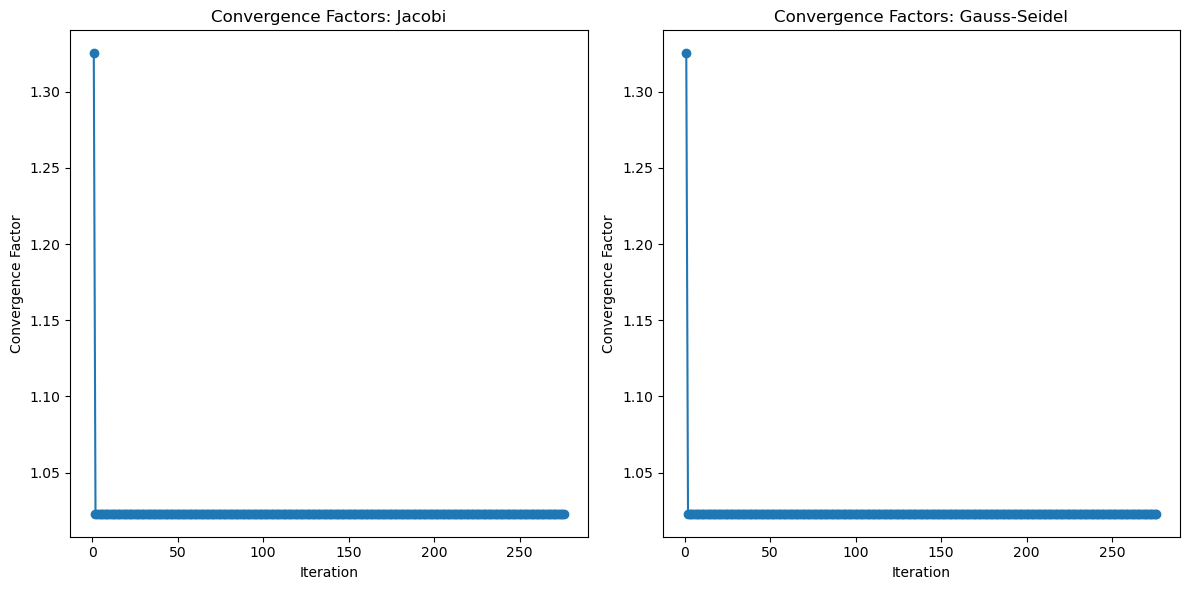

In [1045]:
jacobi_convergence_factors = [n_j[i] / n_j[i+1] for i in range(len(n_j)-1)]
gs_convergence_factors = [n_gs[i] / n_gs[i+1] for i in range(len(n_gs)-1)]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(range(1, len(jacobi_convergence_factors)+1), jacobi_convergence_factors, marker='o')
axs[0].set_title('Convergence Factors: Jacobi')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Convergence Factor')

axs[1].plot(range(1, len(gs_convergence_factors)+1), gs_convergence_factors, marker='o')
axs[1].set_title('Convergence Factors: Gauss-Seidel')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Convergence Factor')

plt.tight_layout()
plt.show()

In [1108]:
alpha = 100
A = create_matrix(alpha)

omega_1 = 0.5
omega_2 = 1
omega_3 = 1.3 

sor_inc_1, sor_inc_2, sor_inc_3 = sor(A, b, omega_1)[1], sor(A, b, omega_2)[1], sor(A, b, omega_3)[1]

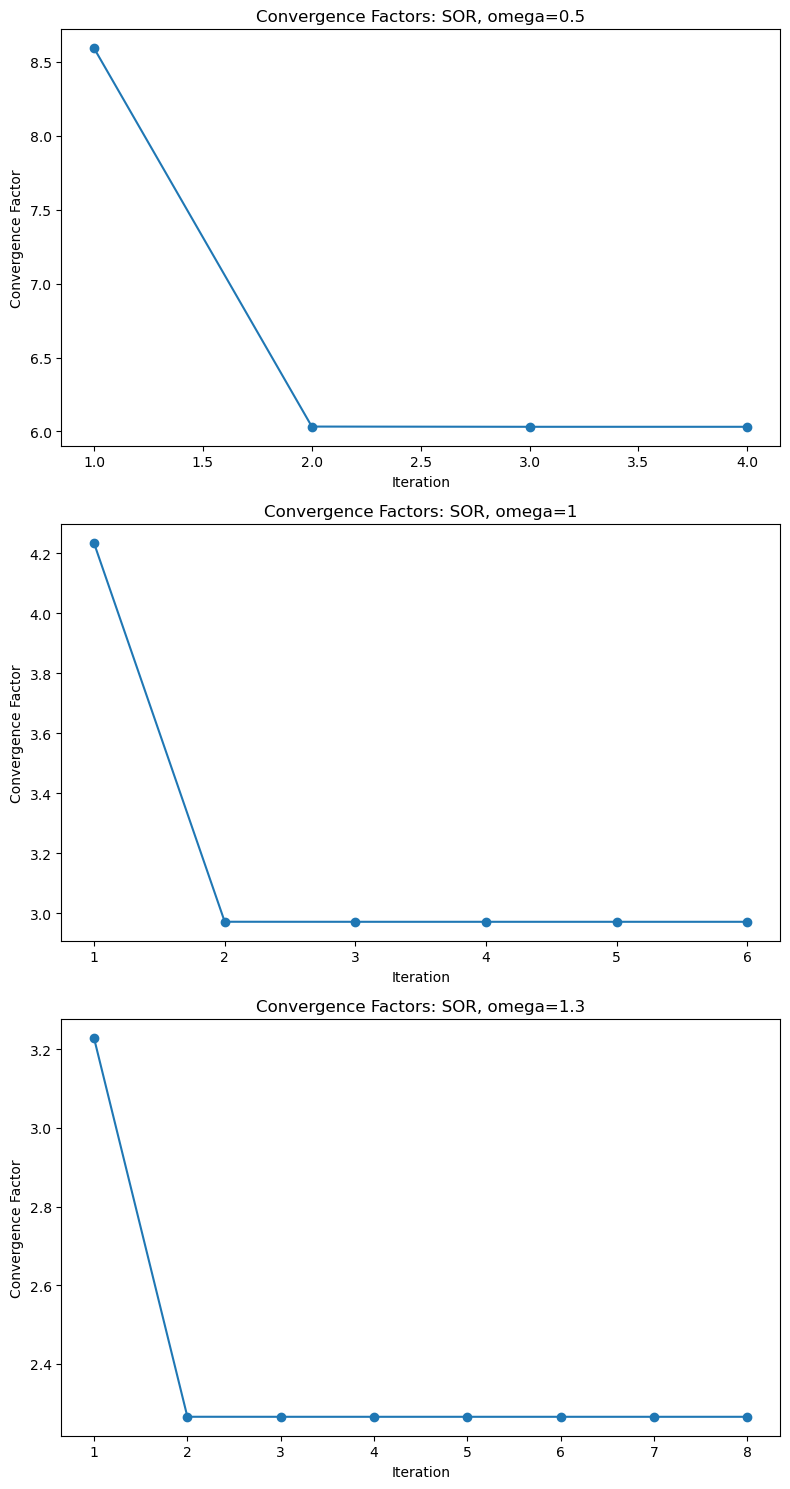

In [1109]:
def plot_convergence_sor(omega_values, convergence_values):

    fig, axs = plt.subplots(len(omega_values), 1, figsize=(8, 5 * len(omega_values)))

    for i, omega in enumerate(omega_values):
        convergence_factor = [convergence_values[i][j] / convergence_values[i][j+1] 
                              for j in range(len(convergence_values[i])-1)]

        axs[i].plot(range(1, len(convergence_factor)+1), convergence_factor, marker='o')
        axs[i].set_title(f'Convergence Factors: SOR, omega={omega}')
        axs[i].set_xlabel('Iteration')
        axs[i].set_ylabel('Convergence Factor')

    plt.tight_layout()
    plt.show()

plot_convergence_sor([omega_1, omega_2, omega_3], [sor_inc_1, sor_inc_2, sor_inc_3])

In [1107]:
def sor_spectral_radius(A, omega):

    L = np.tril(A, -1)
    D = np.diag(np.diag(A))
    U = np.triu(A, 1)

    B_sor = np.dot(np.linalg.inv(D + omega * L), ((1 - omega) * D - omega * U))
    evs = np.linalg.eigvals(B_sor)
    spectral_radius = max(abs(evs))

    return spectral_radius

In [1111]:
for omega in [omega_1, omega_2, omega_3]:
    print(f'Spectral radius with omega={omega}: {sor_spectral_radius(A, omega)}')

Spectral radius with omega=0.5: 0.5024686212613805
Spectral radius with omega=1: 0.06926308473560794
Spectral radius with omega=1.3: 0.35878252445933734


# **5. Conculsions (0.5 pts)**

Summarize in several sentences what you achieved in this task, what were the main obstacles and how you overcome them. You can also add some suggestions how this task can be improved in the future




---

In this task, we implemented three most popular iterative methods, namely Jacobi, Gauss-Seidel and SOR algorithms. We also analyzed and compared some important influential constraints that greatly impact the convergence of these methods.

One of the obstacles was indication of algorithms' nonconvergence. The logic relies on iterative reevaluation of the expression $\|\mathbf{x}_{k+1} - \mathbf{x}_{k}\|/(\|\mathbf{x}_{k+1}\| + \|\mathbf{x}_{k}\|)$. The thing is, that when the algo actually diverges, at some point we end up with the denominator that is equal to infinity. Because the expression like `2.0 / float('inf')` results as $0$, the value becomes less than convergence criterion $\eta$, so the loop stopped and exited with a quite small number of iterations, just as it would appear with a convergent iteration. So we included handling of such cases.

So, in the future there can be included some information on how the output varies in case of convergence / non-convergence of the algorithm.

---